# Testing p-value uniformity under $H_0$ using real quantiles

Here we test and validate p-value uniformity under $H_0$ holds for the real quantiles:

In [1]:
# importing libraries
from sklearn.datasets import load_boston
import numpy as np
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from nonconformist.cp import IcpRegressor
from nonconformist.nc import NcFactory
from sklearn.model_selection import train_test_split
from scipy import stats
import pandas as pd
import os
import time
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
sns.set_palette("Set1")

# original directory
path_original = os.getcwd()
# importing module
from lcv.valid_pred_sets import Valid_pred_sets
from lcv.valid_pred_sets import LinearQuantileRegression
from lcv.valid_pred_sets import GradientBoostingQuantileRegression

# figure path
images_dir = "figures"

To test p-value uniformity, we will apply monte carlo to our test:

In [2]:
# preparing hypothesis object using real quantiles
from simulation import simulation

def prep_hyp_real(kind = "homoscedastic", n = 6250, d = 20, coef = 2, 
B = 1000,random_seed = 1250, sig = 0.05, coverage_evaluator = "RF"):
    sim_obj = simulation(dim = d, coef = coef)
    sim_kind = getattr(sim_obj, kind)
    sim_kind(n, random_seed = random_seed)
    # sim_obj has fit and predict methods
    sim_hyp_obj = Valid_pred_sets(sim_obj, sig, coverage_evaluator)
    sim_hyp_obj.fit(sim_obj.X, sim_obj.y, random_seed = random_seed)
    return sim_hyp_obj

In [3]:
# monte carlo function to assess p-value distribution
def p_value_dist(p_value_file = "p_values.npy",kind = "homoscedastic",  n = 6250, d = 20, coef = 2, B_p = 50, B_m = 250, verbose = 1, par = True):
    p_values = np.zeros(B_p)
    seeds = np.random.randint(1e8, size = B_p)
    print("Starting tests. \n")
    for i in range(B_p):
        sim_hyp_obj = prep_hyp_real(kind = kind, n = n, d = d, coef = coef, random_seed = seeds[i])
        p_values[i] = sim_hyp_obj.monte_carlo_test(B = B_m, random_seed = 1250, par = par)["p-value"]
        if (i + 1) % 10 == 0 and verbose == 1:
            print(f"{i + 1} iterations have passed")
    # saving p-values in a pickle object
    np.save(f"pickle_files/{p_value_file}", p_values)
    return p_values

Finally, we obtain the p-value distribution by monte carlo of monte carlo (which may be significantly costly), taking $B_p = 50$ p-value samples from our $B_m = 250$ monte carlo hypothesis testing:

In [4]:
start = time.time()
print("Obtaining p-value distribution:")
p_values_homoc = p_value_dist(B_p = 150)
end = time.time() - start
print("Time Elapsed: ", end)

Obtaining p-value distribution:
Starting tests. 

10 iterations have passed
20 iterations have passed
30 iterations have passed
40 iterations have passed
50 iterations have passed
60 iterations have passed
70 iterations have passed
80 iterations have passed
90 iterations have passed
100 iterations have passed
110 iterations have passed
120 iterations have passed
130 iterations have passed
140 iterations have passed
150 iterations have passed
Time Elapsed:  29842.642218112946


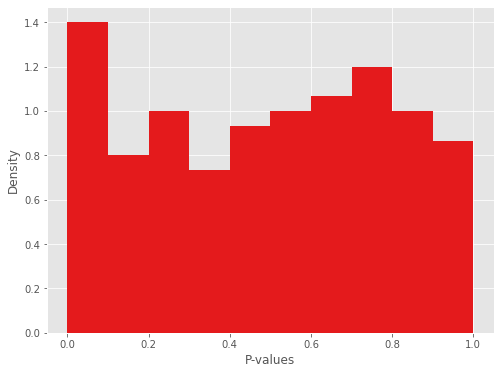

In [5]:
# function that plots p-values and test uniformity using ks test
def test_unif(p_values, figname = "hist_unif.pdf"):
    # testing
    test_res = stats.kstest(p_values, stats.uniform.cdf)

    # plotting
    plt.figure(figsize = (8, 6))
    plt.hist(p_values, density = True)
    plt.xlabel("P-values")
    plt.ylabel("Density")
    plt.savefig(f"{images_dir}/{figname}")
    plt.show()

    return test_res

if 'p_values_homoc' in locals():
    res = test_unif(p_values_homoc, figname = "rf_homoc_proof_of_concept.pdf")
else:
    res = test_unif(np.load("pickle_files/p_values.npy"), figname = "rf_homoc_proof_of_concept.pdf")

Testing results:

In [6]:
res

KstestResult(statistic=0.06666666666666668, pvalue=0.49661171733311316)